# Identifying PII in Student Essays
## Project Summary
The Kaggle Competition we are participating in is the [PII Data Detection hosted by The Learning Agency Lab](https://www.kaggle.com/competitions/pii-detection-removal-from-educational-data/overview). The goal of this competition is to develop a model that detects sensitive personally identifiable information (PII) in student writing. This is necessary to screen and clean educational data so that when released to the public for analysis and archival, the students' risk are mitigated.

## Cloning Repo
Because one of the files is larger than 100MiB, the file could not be uploaded directly to the github repo. The solution found was using git large file system to hold the file and upload the git lfs pointer file in the place of the json.

Git Bash Code:
```
# install git lfs
git lfs install

# start file tracking for git lfs in the repo
git lfs track "*.json"

# stage/commit/push training json
git add train.json
git commit -m "add train.json"
git push
```
After cloning the repo locally, it clones the git lfs pointer file not the data file.

Git Bash Code:
```
# pull file from git lfs system into local repo using any pointer files
git lfs pull
```


## External Data Sources

* [Persuade PII Dataset](https://www.kaggle.com/datasets/thedrcat/persuade-pii-dataset?rvi=1)
  * Essays from Persuade corpus, modified with synthetic PII data and corresponding labels. It was filtered for essays that contain tokens that are relevant to competition.

* [PII | External Dataset](https://www.kaggle.com/datasets/alejopaullier/pii-external-dataset?rvi=1)
  * This is an LLM-generated external dataset that contains generated texts with their corresponding annotated labels in the required competition format.

* [NEW DATASET PII Data Detection](https://www.kaggle.com/datasets/cristaliss/new-dataset-pii-data-detection?rvi=1)
  * This dataset is a modified version of the official training which have the following changes: Revamped Labels, Token Transformation, and Token indexing

* [PII Detection Dataset (GPT)](https://www.kaggle.com/datasets/pjmathematician/pii-detection-dataset-gpt)
  * Personal data was created using python Faker package, which was then fed into the LLM to write an essay on. Overall, it contains 2000 gpt - generated essays and corresponding competition entities used in the essay.

* [AI4privacy-PII](https://www.kaggle.com/datasets/verracodeguacas/ai4privacy-pii)
  * The dataset is crafted using proprietary algorithms, ensuring the creation of synthetic data that avoids privacy violations. The data is meticulously curated with human-in-the-loop validation, ensuring both relevance and quality. It serves a crucial role in addressing the growing concerns around personal data security in AI applications.



## Python Libraries


In [1]:
try:
    import pandas as pd
    import numpy as np
    import spacy as sp
    import re
except DeprecationWarning:
    None

## Loading Datasets


### Official training data

Only load into notebook after pulling from git LFS (see above)

In [2]:
df_train = pd.read_json("../Datasets/Official/train.json")
df_train

,document,full_text,tokens,trailing_whitespace,labels
0,7,Design Thinking for innovation reflexion-Avril...,"[Design, Thinking, for, innovation, reflexion,...","[True, True, True, True, False, False, True, F...","[O, O, O, O, O, O, O, O, O, B-NAME_STUDENT, I-..."
1,10,Diego Estrada\n\nDesign Thinking Assignment\n\...,"[Diego, Estrada, \n\n, Design, Thinking, Assig...","[True, False, False, True, True, False, False,...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O..."
2,16,Reporting process\n\nby Gilberto Gamboa\n\nCha...,"[Reporting, process, \n\n, by, Gilberto, Gambo...","[True, False, False, True, True, False, False,...","[O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O..."
3,20,Design Thinking for Innovation\n\nSindy Samaca...,"[Design, Thinking, for, Innovation, \n\n, Sind...","[True, True, True, False, False, True, False, ...","[O, O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT..."
4,56,Assignment: Visualization Reflection Submitt...,"[Assignment, :, , Visualization, , Reflecti...","[False, False, False, False, False, False, Fal...","[O, O, O, O, O, O, O, O, O, O, O, O, B-NAME_ST..."
...,...,...,...,...,...
6802,22678,EXAMPLE – JOURNEY MAP\n\nTHE CHALLENGE My w...,"[EXAMPLE, –, JOURNEY, MAP, \n\n, THE, CHALLENG...","[True, True, True, False, False, True, True, F...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
6803,22679,Why Mind Mapping?\n\nMind maps are graphical r...,"[Why, Mind, Mapping, ?, \n\n, Mind, maps, are,...","[True, True, False, False, False, True, True, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
6804,22681,"Challenge\n\nSo, a few months back, I had chos...","[Challenge, \n\n, So, ,, a, few, months, back,...","[False, False, False, True, True, True, True, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
6805,22684,Brainstorming\n\nChallenge & Selection\n\nBrai...,"[Brainstorming, \n\n, Challenge, &, Selection,...","[False, False, True, True, False, False, True,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


### Official testing data


In [3]:
df_test = pd.read_json("../Datasets/Official/test.json")
df_test

,document,full_text,tokens,trailing_whitespace
0,7,Design Thinking for innovation reflexion-Avril...,"[Design, Thinking, for, innovation, reflexion,...","[True, True, True, True, False, False, True, F..."
1,10,Diego Estrada\n\nDesign Thinking Assignment\n\...,"[Diego, Estrada, \n\n, Design, Thinking, Assig...","[True, False, False, True, True, False, False,..."
2,16,Reporting process\n\nby Gilberto Gamboa\n\nCha...,"[Reporting, process, \n\n, by, Gilberto, Gambo...","[True, False, False, True, True, False, False,..."
3,20,Design Thinking for Innovation\n\nSindy Samaca...,"[Design, Thinking, for, Innovation, \n\n, Sind...","[True, True, True, False, False, True, False, ..."
4,56,Assignment: Visualization Reflection Submitt...,"[Assignment, :, , Visualization, , Reflecti...","[False, False, False, False, False, False, Fal..."
5,86,Cheese Startup - Learning Launch ​by Eladio Am...,"[Cheese, Startup, -, Learning, Launch, ​by, El...","[True, True, True, True, True, True, True, Fal..."
6,93,Silvia Villalobos\n\nChallenge:\n\nThere is a ...,"[Silvia, Villalobos, \n\n, Challenge, :, \n\n,...","[True, False, False, False, False, False, True..."
7,104,Storytelling The Path to Innovation\n\nDr Sak...,"[Storytelling, , The, Path, to, Innovation, \...","[True, False, True, True, True, False, False, ..."
8,112,Reflection – Learning Launch\n\nFrancisco Ferr...,"[Reflection, –, Learning, Launch, \n\n, Franci...","[True, True, True, False, False, True, False, ..."
9,123,Gandhi Institute of Technology and Management ...,"[Gandhi, Institute, of, Technology, and, Manag...","[True, True, True, True, True, True, False, Tr..."


## Cleaning
To have some uniform input, each source dataframe needs to have a list of tokens from of the source text located in each row.

### Official training dataset
Verify that there are no rows with any null values

In [6]:
# df_train[df_train.isnull().any(axis = 1)]

,document,full_text,tokens,trailing_whitespace,labels


### Official test dataset
Verify that there are no rows with any null values

In [4]:
df_test[df_test.isnull().any(axis = 1)]

,document,full_text,tokens,trailing_whitespace


# Building the model framework

### Loading and Cleaning Datasets

In [7]:
import pandas as pd
import numpy as np
import spacy as sp
import re
import os
import transformers
import torch
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


import torch.nn as nn
from torch import cuda
from torch.utils.data import Dataset, DataLoader

from transformers import BertTokenizerFast, BertConfig, BertForTokenClassification, AutoTokenizer



import warnings
warnings.filterwarnings('ignore')

### Config

This section does initial configuration, loading our the bert pretained model that we use, as well as setting up hyper parameters like `EPOCHS` and `LEARNING_RATE`

In [58]:
class Config():
    def __init__(self, platform, model_name, pretrained_model_name):
        # platform = 'Kaggle'# 
        if platform == 'Kaggle':
            pretrained_model = '../input/huggingface-bert/' + pretrained_model_name + '/'
            train_path = 'path_TBD/train.json'
            # test_path = ''
            model_path = 'path_TBD/' + model_name
        elif platform == 'local':
            model_path = '../models/bert_models/' + model_name
        
        self.config = {
            'MAX_LEN': 128,
            'TRAIN_BATCH_SIZE': 4,
            'VALID_BATCH_SIZE': 2,
            'EPOCHS': 5,
            'LEARNING_RATE':1e-5,
            'MAX_GRAD_NORM': 10,
            'device': 'cuda' if torch.cuda.is_available() else 'cpu',
            # 'device': 'cpu',
            'model_path': model_path,
            'pretrained_model': pretrained_model_name,
            'tokenizer': BertTokenizerFast.from_pretrained(pretrained_model_name)
        }

In [59]:
platform = 'local'
pretrainend_model_name = 'bert-large-cased'
model_num = 1
model_name = 'model' + str(model_num) + '-' + pretrainend_model_name +'.bin'

config = Config(platform,model_name, pretrainend_model_name).config

Requires:
```git lfs track "*.safetensors"```
to clone model from github

If using IDE, Run 
```
python -m spacy download en_core_web_sm
```
in the bash to install the english spacy pipline

## Official Datasets

### Data and Exploration

In [138]:
df = pd.read_json("../Datasets/Official/train.json")
df['labels']

0       [O, O, O, O, O, O, O, O, O, B-NAME_STUDENT, I-...
1       [B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O...
2       [O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O...
3       [O, O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT...
4       [O, O, O, O, O, O, O, O, O, O, O, O, B-NAME_ST...
                              ...                        
6802    [O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...
6803    [O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...
6804    [O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...
6805    [O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...
6806    [O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...
Name: labels, Length: 6807, dtype: object

In [144]:
# df[df.isnull().any(axis = 1)]
df['labels'][0]

['O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-NAME_STUDENT',
 'I-NAME_STUDENT',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 '

## Hypothesis testing

### Proportion of PII as a percentage of the text

H0: The proportion of PII in each text is zero.​

Ha: The proportion of PII in each text is not zero.

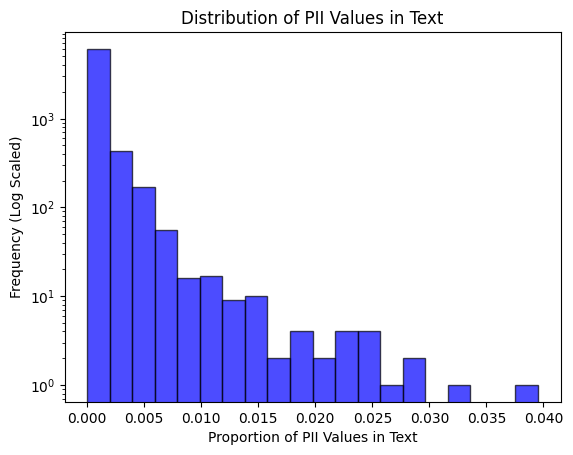

In [236]:
import numpy as np

labels = df['labels']

non_o_values = df.apply(lambda line: sum(1 for x in line['labels'] if x != 'O')/ len(line['labels']), axis = 1)

proportions_array = np.array(non_o_values)

plt.hist(proportions_array, bins=20, color='blue', edgecolor='black', alpha=0.7)
plt.xlabel('Proportion of PII Values in Text')
plt.ylabel('Frequency (Log Scaled)')
plt.yscale('log')
plt.title('Distribution of PII Values in Text')
plt.show()

Since the p-value is below alpha (0.01) we reject the null hypothesis.

In [239]:
import scipy.stats as stats
t_statistic, p_value = stats.ttest_1samp(proportions_array, 0)

print("t-statistic:", t_statistic)
print("p-value:", p_value)

t-statistic: 22.91577515140053
p-value: 5.142762049402132e-112


### Proprtion of each type of PII

H0: All PII have equal likelihood of appearing.​

Ha: Name PII are more likely to appear.​

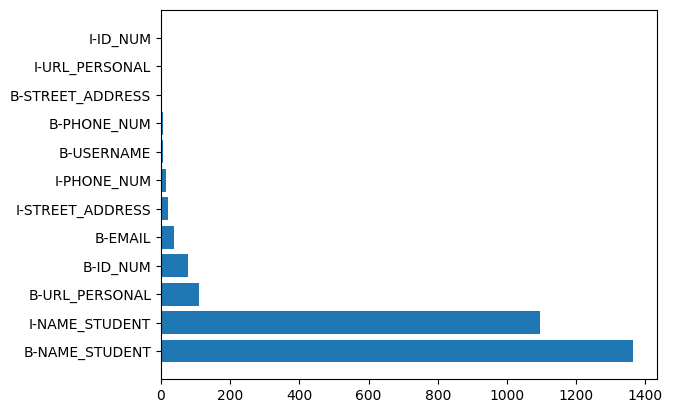

In [ ]:
from collections import Counter
c = Counter()
df.apply(lambda line: c.update(line.labels), axis = 1)
c_pii = c.most_common()[1:]
c_key, c_val = zip(*c_pii)
plt.barh(c_key, c_val)
plt.show()

### Positional distribution of most popular PII

H0: PII is evenly distributed across the length of an essay.​​

Ha: PII is more likely to appear in the beginning of the essay.​

Text(0.5, 1.0, 'B-URL')

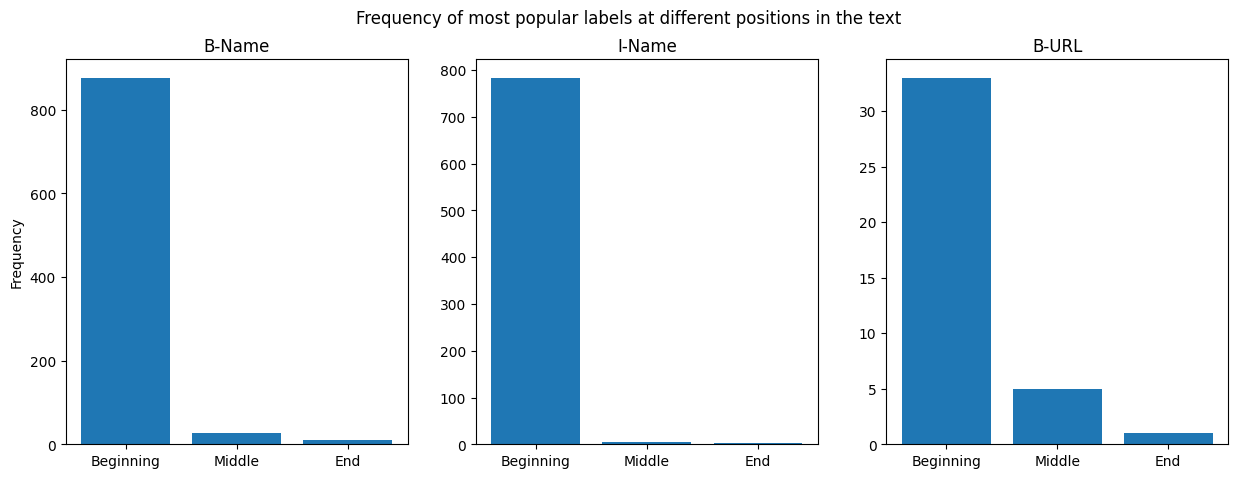

In [234]:
# Creates a dictionary for each position in the text (beginning, middle, and end)
positions = {
    'beginning': lambda x: x[:int(len(x)/3)],
    'middle': lambda x: x[int(len(x)/3):int(-len(x)/3)],
    'end': lambda x: x[int(-len(x)/3):-1]
}

label_counts = {pos: {} for pos in positions}
for arr in df['labels']:
    for pos, func in positions.items():
            arr = func(arr)
            for label in arr:
                if label in label_counts[pos]:
                        label_counts[pos][label] += 1
                else:
                        label_counts[pos][label] = 1


beginning_labels = label_counts['beginning']
middle_labels = label_counts['middle']
end_labels = label_counts['end']

# B-NAME_STUDENT
# I-NAME_STUDENT
# B-URL_PERSONAL

B_name = [beginning_labels['B-NAME_STUDENT'],
        middle_labels['B-NAME_STUDENT'],
        end_labels['B-NAME_STUDENT']]

I_name = [beginning_labels['I-NAME_STUDENT'],
        middle_labels['I-NAME_STUDENT'],
        end_labels['I-NAME_STUDENT']]

B_url = [beginning_labels['B-URL_PERSONAL'],
        middle_labels['B-URL_PERSONAL'],
        end_labels['B-URL_PERSONAL']]

locations = ['Beginning', 'Middle', 'End']

fig, ax = plt.subplots(1,3, figsize=(15, 5))
fig.suptitle('Frequency of most popular labels at different positions in the text')
ax[0].set_ylabel('Frequency')
ax[0].bar(locations, B_name)
ax[0].set_title('B-Name')
ax[1].bar(locations, I_name)
ax[1].set_title('I-Name')
ax[2].bar(locations, B_url)
ax[2].set_title('B-URL')

In [ ]:
c_pii

[('B-NAME_STUDENT', 1365),
 ('I-NAME_STUDENT', 1096),
 ('B-URL_PERSONAL', 110),
 ('B-ID_NUM', 78),
 ('B-EMAIL', 39),
 ('I-STREET_ADDRESS', 20),
 ('I-PHONE_NUM', 15),
 ('B-USERNAME', 6),
 ('B-PHONE_NUM', 6),
 ('B-STREET_ADDRESS', 2),
 ('I-URL_PERSONAL', 1),
 ('I-ID_NUM', 1)]

In [ ]:
labels_to_ids = {k: v for v, k in enumerate(c.keys())}
ids_to_labels = {v: k for v, k in enumerate(c.keys())}
labels_to_ids

{'O': 0,
 'B-NAME_STUDENT': 1,
 'I-NAME_STUDENT': 2,
 'B-URL_PERSONAL': 3,
 'B-EMAIL': 4,
 'B-ID_NUM': 5,
 'I-URL_PERSONAL': 6,
 'B-USERNAME': 7,
 'B-PHONE_NUM': 8,
 'I-PHONE_NUM': 9,
 'B-STREET_ADDRESS': 10,
 'I-STREET_ADDRESS': 11,
 'I-ID_NUM': 12}

### Preprocessing

First we scoured the data to find the usuable text with our pretrained model with Regex.

In [ ]:
pattern = re.compile('\xa0|\uf0b7|\u200b')
df.loc[:,'full_text'] = df.loc[:,'full_text'].replace(pattern, ' ')
df.loc[:,'tokens'] = df.loc[:,'tokens'].apply(lambda line: [tok for tok in line if not re.search(pattern,tok)])

df_usable = df.iloc[df[~(df.tokens.apply(len) != df.labels.apply(len))].index]
1-(len(df_usable))/len(df.document)

0.06184809754664311

We created a function to tokenize and label all of the lines in the dataset.

In [ ]:
def make_smaller_inputs(dataframe):
    df_out = pd.DataFrame(columns = ['tokens','labels'])
    counter = 0
    max_len = config['MAX_LEN']
    
    for _,line in dataframe.iterrows():
        tokens = line.tokens
        labels = line.labels
        items = range(0,len(tokens),max_len)
        
        for i in items:
            df_out.at[counter,'tokens'] = tokens[i:i+max_len]
            df_out.at[counter,'labels'] = labels[i:i+max_len]
            counter += 1
            
    return df_out

In [ ]:
df_model_input = make_smaller_inputs(df_usable)
df_model_input.head()

,tokens,labels
0,"[Design, Thinking, for, innovation, reflexion,...","[O, O, O, O, O, O, O, O, O, B-NAME_STUDENT, I-..."
1,"[significant, material, investment, and, can, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
2,"[starting, point, , generates, ideas, /, work...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
3,"[the, series, , of, questions, according, to,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
4,"[images, and, interconnections, ., This, secon...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


In [ ]:
len(df_model_input.index)

39146

### Creating the training and testing split

In [ ]:
df_train, df_test = train_test_split(df_model_input.sample(n=10000), test_size=0.2)

### Formatting split

In [ ]:
df_train.reset_index(drop = True, inplace=True)
df_train

,tokens,labels
0,"[and, more, clear, visions, of, what, we, 're,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
1,"[to, the, performing, organization, and, help,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
2,"[by, saying, that, I, have, not, much, experie...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
3,"[in, order, to, be, persuasive, but, also, gen...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
4,"[of, a, crisis, ,, and, on, the, other, hand, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
...,...,...
7995,"[on, the, participants, sharing, weekly, short...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
7996,"[that, throughout, the, construction, , proce...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
7997,"[clients, of, ours, ,, who, were, signing, the...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
7998,"[mind, mapping, ., Especially, in, research, ,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


In [ ]:
df_test.reset_index(drop = True, inplace=True)
df_test

,tokens,labels
0,"[with, reality, ., I, chose, visualization, .,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
1,"[some, new, method, and, ideas, ., We, spent, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
2,"[., \n\n, Problem, :, Many, employees, were, l...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
3,"[can, get, future, offers, ., the, potential, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
4,"[understand, each, profile, better, and, \n\n,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
...,...,...
1995,"[most, importantly, ,, why, did, this, specifi...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
1996,"[deposits, and, then, , increase, the, branch...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
1997,"[Applying, Storytelling, for, Design, Thinking...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
1998,"[Reflection, –, Learning, Launch, (, Module, 4...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


# Model


adapted from 
https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/BERT/Custom_Named_Entity_Recognition_with_BERT_only_first_wordpiece.ipynb#scrollTo=Eh3ckSO0YMZW

In [ ]:
class dataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __getitem__(self, index):
        # step 1: get the sentence and word labels 
        tokens = self.data.tokens[index]
        word_labels = self.data.labels[index]

        # step 2: use tokenizer to encode sentence (includes padding/truncation up to max length)
        # BertTokenizerFast provides a handy "return_offsets_mapping" functionality for individual tokens
        encoding = self.tokenizer(tokens,
                                  is_split_into_words=True,
                                  return_offsets_mapping=True,
                                  padding='max_length',
                                  truncation=True,
                                  max_length=self.max_len)

        # step 3: create token labels only for first word pieces of each tokenized word
        labels = [ labels_to_ids[label] for label in word_labels]
        # code based on https://huggingface.co/transformers/custom_datasets.html#tok-ner
        # create an empty array of -100 of length max_length
        encoded_labels = np.ones(len(encoding["offset_mapping"]), dtype=int) * -100

        # set only labels whose first offset position is 0 and the second is not 0
        i = 0
        for idx, mapping in enumerate(encoding["offset_mapping"]):
            if mapping[0] == 0 and mapping[1] != 0:
                # overwrite label
                encoded_labels[idx] = labels[i]
                i += 1

        # step 4: turn everything into PyTorch tensors
        item = {key: torch.as_tensor(val) for key, val in encoding.items()}
        item['labels'] = torch.as_tensor(encoded_labels)

        return item

    def __len__(self):
        return self.len

In [ ]:
training_set = dataset(df_train, config['tokenizer'], config['MAX_LEN'])
testing_set = dataset(df_test, config['tokenizer'], config['MAX_LEN'])

In [ ]:
training_set[2]["input_ids"].unsqueeze(0)

tensor([[  101,  1118,  2157,  1115,   146,  1138,  1136,  1277,  2541,  1165,
          1122,  2502,  1106,  7204,  1958,  1137,  3687, 12606,  3798,  1614,
           119,  1599,   146,  1355,  1113,  1106,  2934,   170,  1353,  1226,
          1104,  1139,  1297,   787,   188,  5012,   119,   146,  1125,  1198,
          2063,  1139,  5368,  1105,  1108,  2152,  1118,  1103,  2958,  1104,
         12626,  1111,  1217,  1103,  8190,   787,  1499,  3365,  1104,  1103,
          2072,  2102,  6402,  1107,  1103,  8179,  3303,  1118,  1103,  1970,
          2464,  1104,  7934,  2531,   117,  1726,   119,  1247,  1108,   170,
          1974,  1104,  9010,  1105, 13542,  8342,  1107,  1121,  1155,  3091,
          1105,  7430,  1164,  1293,  1992,   146,  1156,  1294,  1122,  1107,
          1103,  1909,  1552,   119,  1337,  1108,  1145,  1165,  1103,  7157,
          1206,   170,  1842,  1601,  2130,  1910,  1104,  2317,  1105,  1143,
          1108,   171, 21853,  1158,  1154, 11483,  

In [ ]:
for token, label in zip(config['tokenizer'].convert_ids_to_tokens(training_set[0]["input_ids"]), training_set[0]["labels"]):
    print('{0:10}  {1}'.format(token, label))

[CLS]       -100
and         0
more        0
clear       0
visions     0
of          0
what        0
we          0
'           0
re          -100
trying      0
to          0
change      0
.           0
What        0
I           0
would       0
change      0
and         0
what        0
I           0
learned     0
from        0
the         0
course      0
is          0
to          0
focus       0
more        0
on          0
people      0
and         0
less        0
on          0
the         0
process     0
,           0
because     0
paying      0
attention   0
to          0
the         0
human       0
dimension   0
is          0
important   0
and         0
a           0
key         0
to          0
success     0
,           0
as          0
well        0
as          0
finding     0
and         0
asking      0
the         0
right       0
questions   0
that        0
are         0
likely      0
to          0
el          0
##icit      -100
the         0
response    0
we          0
’          

Setting training and testing parameters

In [ ]:
train_params = {'batch_size': config["TRAIN_BATCH_SIZE"],
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': config["VALID_BATCH_SIZE"],
               'shuffle': True,
               'num_workers': 0
               }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [ ]:
model = BertForTokenClassification.from_pretrained(config['pretrained_model'], num_labels=len(labels_to_ids))
model.to(config['device'])

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-large-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), 

expected loss of inital model is 
-ln(1/(# of classes))

In [ ]:
-np.log(1/len(labels_to_ids))

2.5649493574615367

In [ ]:
inputs = training_set[2]
input_ids = inputs["input_ids"].unsqueeze(0)
attention_mask = inputs["attention_mask"].unsqueeze(0)
labels = inputs["labels"].unsqueeze(0)

input_ids = input_ids.to(config['device'])
attention_mask = attention_mask.to(config['device'])
labels = labels.to(config['device'])

outputs = model(input_ids.long(), attention_mask=attention_mask.long(), labels=labels.long())
initial_loss = outputs[0]
initial_loss

tensor(2.4932, device='cuda:0', grad_fn=<NllLossBackward0>)

Limit of my comprehension as of 3/7

In [ ]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=config['LEARNING_RATE'])

In [ ]:
# Defining the training function on the 80% of the dataset for tuning the bert model
def train(epoch):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    # put model in training mode
    model.train()

    for idx, batch in enumerate(training_loader):

        ids = batch['input_ids'].to(config['device'], dtype = torch.long)
        mask = batch['attention_mask'].to(config['device'], dtype = torch.long)
        labels = batch['labels'].to(config['device'], dtype = torch.long)

        outputs = model(input_ids=ids.long(), attention_mask=mask.long(), labels=labels.long())
        loss = outputs[0]
        tr_logits = outputs[1]
        tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += labels.size(0)

        if idx % 100==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per 100 training steps: {loss_step}")

        # compute training accuracy
        flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
        active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
        
        # only compute accuracy at active labels
        active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        #active_labels = torch.where(active_accuracy, labels.view(-1), torch.tensor(-100).type_as(labels))

        labels = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)

        tr_labels.extend(labels)
        tr_preds.extend(predictions)

        tmp_tr_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy

        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=config['MAX_GRAD_NORM']
        )

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training accuracy epoch: {tr_accuracy}")

### Determine whether to run training

In [ ]:
run = True

In [ ]:
if run:
    for epoch in range(config['EPOCHS']):
        print(f"Training epoch: {epoch + 1}")
        train(epoch)
    run = False

Training epoch: 1
Training loss per 100 training steps: 2.4671030044555664


Training loss per 100 training steps: 0.13581085409035465
Training loss per 100 training steps: 0.06964046341733109
Training loss per 100 training steps: 0.04837622243995729
Training loss per 100 training steps: 0.03781530445591405
Training loss per 100 training steps: 0.030790135770896263
Training loss per 100 training steps: 0.02629079072133885
Training loss per 100 training steps: 0.023056645322444592
Training loss per 100 training steps: 0.020585413556673142
Training loss per 100 training steps: 0.018547631118673476
Training loss per 100 training steps: 0.016939612955358424
Training loss per 100 training steps: 0.015650272625616104
Training loss per 100 training steps: 0.014801967232853045
Training loss per 100 training steps: 0.013843413075958063
Training loss per 100 training steps: 0.013084693081064927
Training loss per 100 training steps: 0.01236475149879244
Training loss per 100 training steps: 0.011743409185745884
Training loss per 100 training steps: 0.011338210141635448
Tra

KeyError: 9637
KeyError: 2326
KeyError: 10126

Training epoch: 1
Training loss per 100 training steps: 2.7618727684020996
Training loss per 100 training steps: 0.16489562393272167
Training loss per 100 training steps: 0.08506841691869974
Training loss per 100 training steps: 0.05866454021836572
Training loss per 100 training steps: 0.0448566305917337
Training loss per 100 training steps: 0.03700114993198204
Training loss per 100 training steps: 0.03148505321677023
Training loss per 100 training steps: 0.027487104761941668
Training loss per 100 training steps: 0.02472412176731074
Training loss per 100 training steps: 0.022315634308862485
Training loss per 100 training steps: 0.020358747662810657
Training loss per 100 training steps: 0.018798588405868257
Training loss per 100 training steps: 0.01771995336807788
Training loss per 100 training steps: 0.016532918837726875
Training loss per 100 training steps: 0.01559861331037873
Training loss per 100 training steps: 0.014847838147105554
Training loss per 100 training steps: 0.014085038305332555
Training loss per 100 training steps: 0.01341761080099804
Training loss per 100 training steps: 0.012970763410538278
Training loss per 100 training steps: 0.01238988842706385
Training loss per 100 training steps: 0.011946241673651273
Training loss per 100 training steps: 0.011436048718409393
Training loss per 100 training steps: 0.01119401791093853
Training loss per 100 training steps: 0.01077323481422868
Training loss per 100 training steps: 0.010417857425509335
Training loss per 100 training steps: 0.010077849820839403
Training loss per 100 training steps: 0.009746479573238202
Training loss per 100 training steps: 0.009407942358349542
Training loss per 100 training steps: 0.00914617103634552
Training loss per 100 training steps: 0.008907846019452265
Training loss per 100 training steps: 0.008657838686139311
Training loss per 100 training steps: 0.008449268298699422
Training loss per 100 training steps: 0.008295341608228847
Training loss per 100 training steps: 0.008189213672816328
Training loss per 100 training steps: 0.007978749200488505
Training loss per 100 training steps: 0.007829300027857769
Training loss per 100 training steps: 0.0077915255697598535
Training loss per 100 training steps: 0.007615185001152273
Training loss per 100 training steps: 0.007460967634521881
Training loss per 100 training steps: 0.0073240728916386
Training loss epoch: 0.007183262327166176
Training accuracy epoch: 0.9988009906964034

Execution Time: 2h 33m 45s
Batch Size: 2
LR: 1e-5
Optimizer: Adam

In [ ]:
import os

directory = config['model_path']

if not os.path.exists(directory):
    os.makedirs(directory)

# save vocabulary of the tokenizer
config['tokenizer'].save_vocabulary(directory)
# save the model weights and its configuration file
save_model = True
if save_model:  
    model.save_pretrained(directory)
    print('All files saved')

All files saved


In [ ]:
model1 = BertForTokenClassification.from_pretrained(config['model_path'], num_labels=len(labels_to_ids))
model1.to(config['device'])

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), 

In [ ]:
def valid(model, testing_loader):
    # put model in evaluation mode
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []
    
    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):
            
            ids = batch['input_ids'].to(config['device'], dtype = torch.long)
            mask = batch['attention_mask'].to(config['device'], dtype = torch.long)
            labels = batch['labels'].to(config['device'], dtype = torch.long)

            outputs = model(input_ids=ids.long(), attention_mask=mask.long(), labels=labels.long())
            
            loss = outputs[0]
            eval_logits = outputs[1]
            eval_loss += loss.item()
            
            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)
        
            if idx % 100==0:
                loss_step = eval_loss/nb_eval_steps
                print(f"Validation loss per 100 evaluation steps: {loss_step}")
            
            # compute evaluation accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            
            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        
            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)
            
            eval_labels.extend(labels)
            eval_preds.extend(predictions)
            
            tmp_eval_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    labels = [ids_to_labels[id.item()] for id in eval_labels]
    predictions = [ids_to_labels[id.item()] for id in eval_preds]
    
    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return labels, predictions

In [ ]:
labels, predictions = valid(model1, testing_loader)

Validation loss per 100 evaluation steps: 3.0572705327358562e-06
Validation loss per 100 evaluation steps: 0.0013151844329923274
Validation loss per 100 evaluation steps: 0.0021129329224563592
Validation loss per 100 evaluation steps: 0.002045829712142373
Validation loss per 100 evaluation steps: 0.0027985881419189222
Validation loss per 100 evaluation steps: 0.002756651452280933
Validation loss per 100 evaluation steps: 0.002401162180087897
Validation loss per 100 evaluation steps: 0.0024765204420970793
Validation loss per 100 evaluation steps: 0.0024215343536316404
Validation loss per 100 evaluation steps: 0.0023874387011124623
Validation Loss: 0.0022458603493150805
Validation Accuracy: 0.9995625754673617


Validation loss per 100 evaluation steps: 4.3060306779807433e-05
Validation loss per 100 evaluation steps: 0.0003900290700612189
Validation loss per 100 evaluation steps: 0.0008872096701063255
Validation loss per 100 evaluation steps: 0.0017595441007012122
Validation loss per 100 evaluation steps: 0.001834294180439077
Validation loss per 100 evaluation steps: 0.002054755131990794
Validation loss per 100 evaluation steps: 0.0022841157073565164
Validation loss per 100 evaluation steps: 0.0023434926568139487
Validation loss per 100 evaluation steps: 0.0024022069384918767
Validation loss per 100 evaluation steps: 0.0026039667075087917
Validation Loss: 0.0025191350434306515
Validation Accuracy: 0.9994422838479019
Execution Time: 08m 07.238s

In [ ]:
print(classification_report(labels, predictions))

                precision    recall  f1-score   support

      B-ID_NUM       0.00      0.00      0.00         7
B-NAME_STUDENT       0.80      0.21      0.34        56
    B-USERNAME       0.00      0.00      0.00         1
      I-ID_NUM       0.00      0.00      0.00         1
I-NAME_STUDENT       0.55      0.50      0.52        46
             O       1.00      1.00      1.00    212818

      accuracy                           1.00    212929
     macro avg       0.39      0.29      0.31    212929
  weighted avg       1.00      1.00      1.00    212929



About 50% for getting student names correct, 0% for the others